<a href="https://colab.research.google.com/github/ffabi/szoweb/blob/main/Sz%C3%B6web_HF_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Szöveg- és webbányászat szorgalmi feladat

Füleki Fábián - AEP0TG


In [2]:
# importing the necessary libraries

!pip3 -q install transformers

import pandas as pd
import numpy as np
from google.colab import files
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from tqdm import tqdm, trange
from wordcloud import WordCloud

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification, AdamW
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
plt.figure(dpi=450)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

     |████████████████████████████████| 1.4MB 9.1MB/s 
     |████████████████████████████████| 2.9MB 30.6MB/s 
     |████████████████████████████████| 890kB 40.8MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<Figure size 2700x1800 with 0 Axes>

Load the data and lets have a look at it

In [3]:
train_data = pd.read_csv("https://raw.githubusercontent.com/ffabi/szoweb/main/TrainNER.csv", encoding="latin1", sep=";").fillna(method="ffill")
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196646 entries, 0 to 196645
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sentence #  196646 non-null  object
 1   Word        196646 non-null  object
 2   POS         196646 non-null  object
 3   Tag         196646 non-null  object
dtypes: object(4)
memory usage: 6.0+ MB


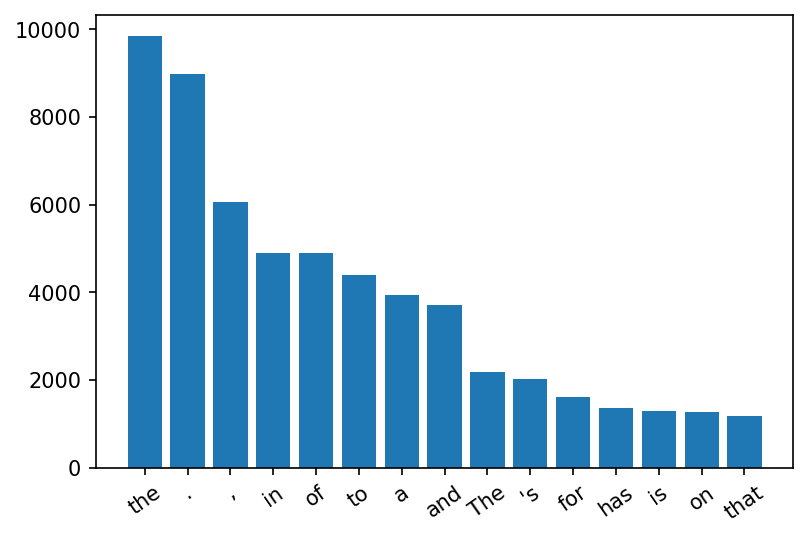

In [4]:
data = train_data["Word"].value_counts().head(15)
plt.figure(dpi=150)
plt.bar(range(len(data)), data.values, )
plt.xticks(range(len(data)), data.index.values, size='medium', rotation=35)
plt.show()

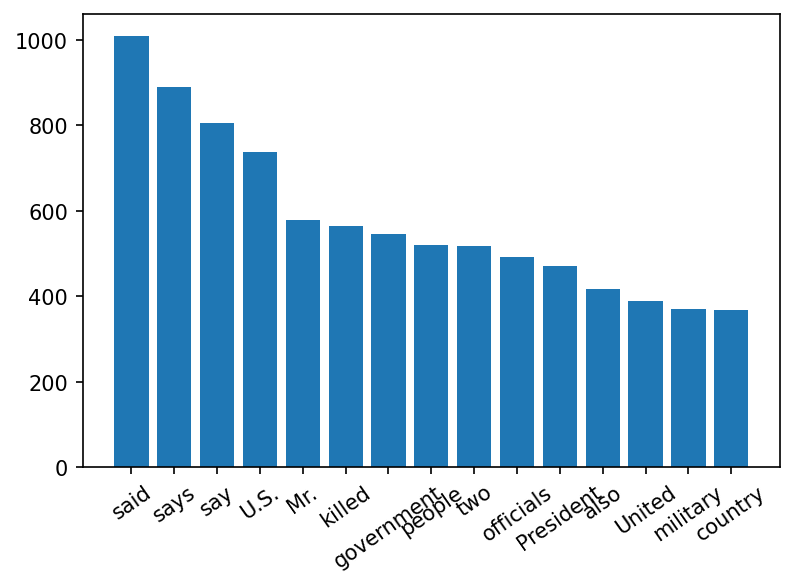

In [5]:


data = train_data[~train_data["Word"].str.lower().isin(stopwords.words('english') + [".", ",", '"', "'s"])]["Word"].value_counts().head(15)
plt.figure(dpi=150)
plt.bar(range(len(data)), data.values, )
plt.xticks(range(len(data)), data.index.values, size='medium', rotation=35)
plt.show()

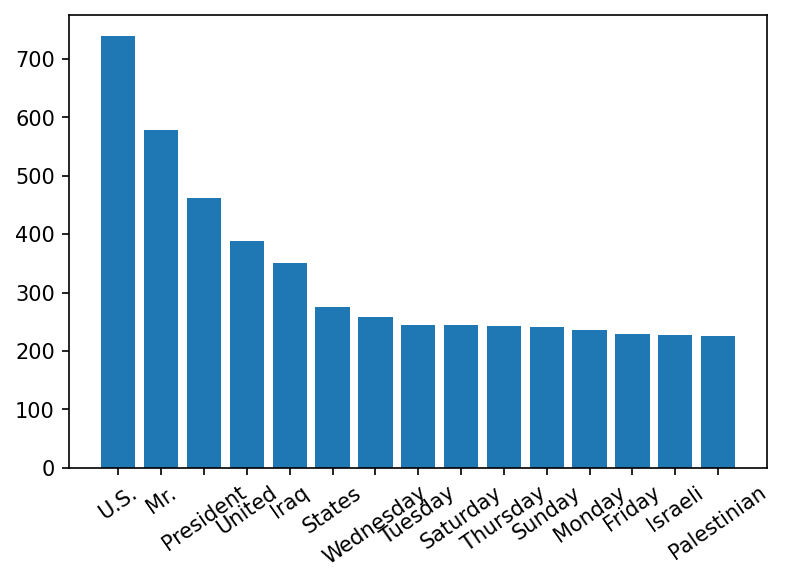

In [6]:
data = train_data.loc[train_data['Tag'] != "O"]["Word"].value_counts().head(15)
plt.figure(dpi=150)
plt.bar(range(len(data)), data.values, )
plt.xticks(range(len(data)), data.index.values, size='medium', rotation=35)
plt.show()

<Figure size 2160x720 with 0 Axes>

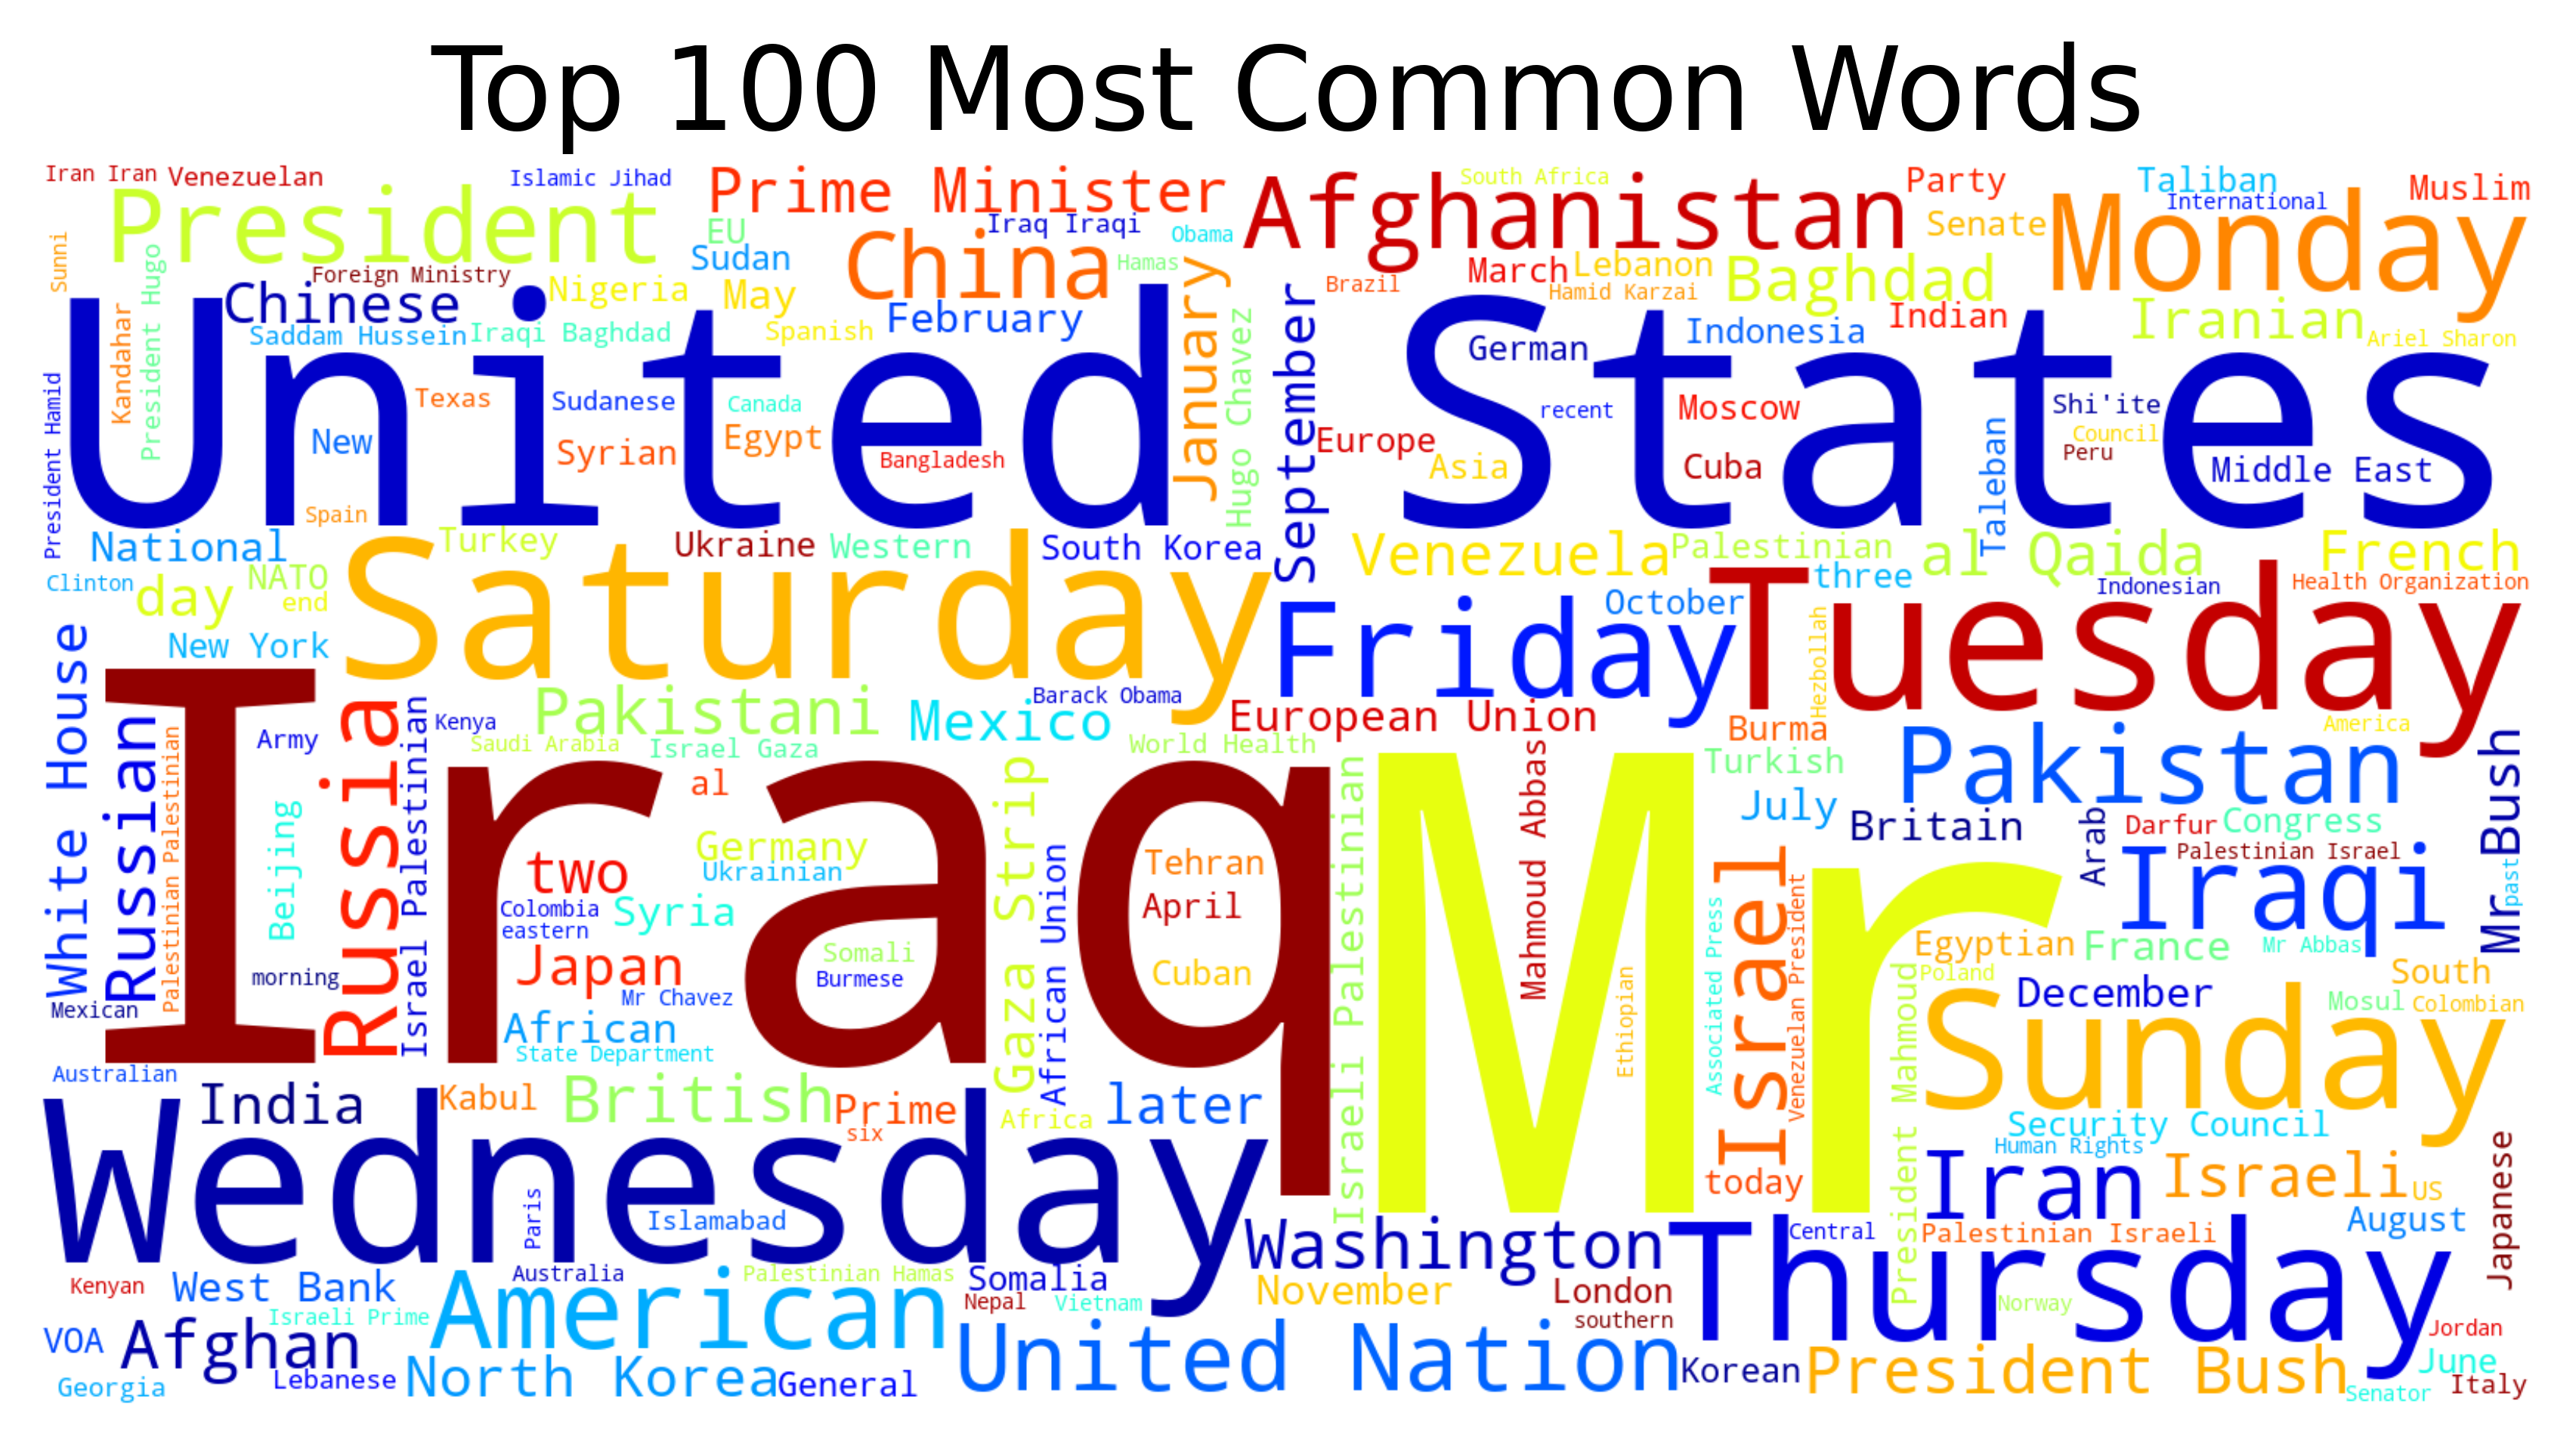

In [7]:
text = " ".join(train_data.loc[train_data['Tag'] != "O"]["Word"].values.tolist())
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap="jet").generate(text)
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.figure(dpi=550)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

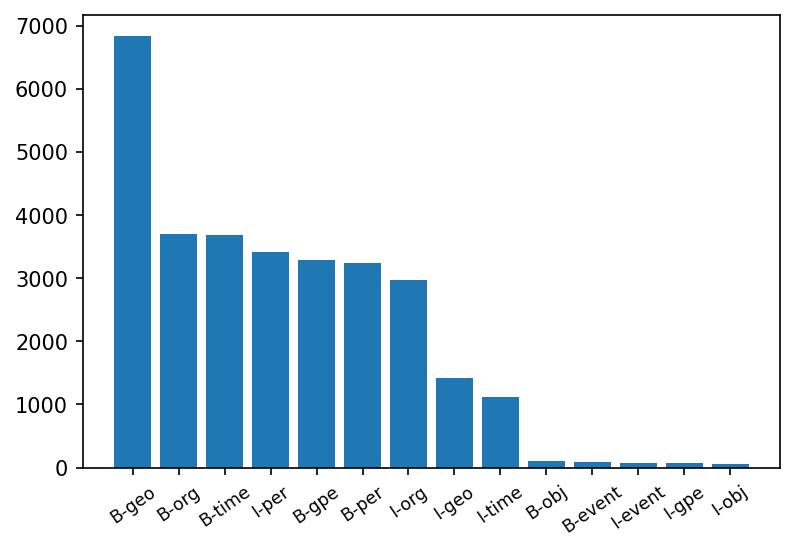

In [8]:
data = train_data.loc[train_data['Tag'] != "O"]["Tag"].value_counts()
plt.figure(dpi=150)
plt.bar(range(len(data)), data.values, )
plt.xticks(range(len(data)), data.index.values, size='small', rotation=35)
plt.show()

In [9]:
len(train_data['Tag'])

196646

In [10]:
# train_data.loc[(train_data['Tag'] != "O") & (train_data['Word'] == ",")]

In [11]:
keys = train_data.loc[train_data['Tag'] != "O"]["Tag"].value_counts().keys()
df = pd.DataFrame({'Label' : [], "1":[], "2":[], "3":[], "4":[], "5":[]})
for k in sorted(sorted(keys), key=lambda key: key[2:]):
    # print(k, "\t", ", ".join(train_data.loc[train_data['Tag'] == k]["Word"].value_counts().head(5).keys()))
    words = train_data.loc[train_data['Tag'] == k]["Word"].value_counts().head(5).keys()
    df = df.append(pd.DataFrame({"Label": [k], "1":[words[0]], "2":[words[1]], "3":[words[2]], "4":[words[3]], "5":[words[4]]}))

df

,Label,1,2,3,4,5
0,B-event,II,World,Olympic,Australian,Hurricane
0,I-event,War,Open,Games,Cup,II
0,B-geo,U.S.,Iraq,United,Israel,Iran
0,I-geo,States,Korea,Strip,East,of
0,B-gpe,Israeli,Palestinian,Iraqi,Afghan,Russian
0,I-gpe,Serb,States,Korea,d'Ivoire,Republic
0,B-obj,Vioxx,Twitter,English,GDP,Web
0,I-obj,Trade,Agreement,Street,of,Airport
0,B-org,U.S.,United,U.N.,Taleban,Hamas
0,I-org,Nations,of,and,Union,House


In [12]:
def aggregator(grouped):
    return [(w, p, t) for w, p, t in zip(grouped["Word"].values.tolist(), grouped["POS"].values.tolist(), grouped["Tag"].values.tolist())]

def get_sentences(df):
    grouped = [sentence for sentence in df.groupby("Sentence #", sort = False).apply(aggregator)]
    sentences = [[word[0] for word in sentence] for sentence in grouped]
    return sentences

def get_labels(df):
    grouped = [sentence for sentence in df.groupby("Sentence #", sort = False).apply(aggregator)]
    labels = [[word[2] for word in sentence] for sentence in grouped]
    return labels

sentences = get_sentences(train_data)
labels = get_labels(train_data)


In [13]:
print(" ".join(sentences[0]))
print(labels[0])

President Karzai thanked his allies for their help in battling terrorism .
['B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


70


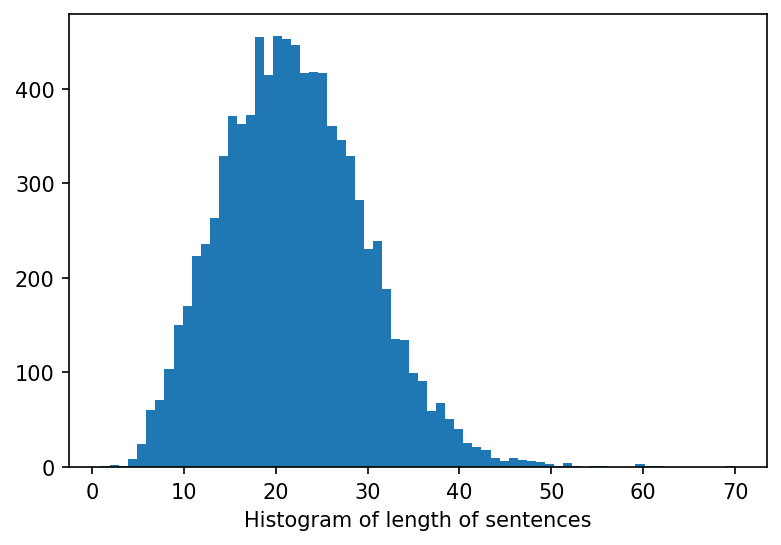

In [14]:
print(max([len(s) for s in sentences]))
plt.figure(dpi=150)

plt.hist([len(s) for s in sentences],bins= 70)
plt.xlabel("Histogram of length of sentences")
plt.show()

In [15]:
import numpy as np
print(np.asarray([len(s) for s in sentences]).mean())
print(np.asarray([len(s) for s in sentences]).std())
print(np.asarray([len(s) for s in sentences]).min())
print(np.asarray([len(s) for s in sentences]).max())

21.849555555555554
7.877790850952952
1
70


In [16]:
for s in sentences:
    if len(s) <=3:
        print(" ".join(s))

John Garang
Janice Karpinski
George W. Bush
The


Training phase

The implementation of the training is based on https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

In [17]:
tag_values = list(set(train_data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

MAX_LEN = 75
bs = 32

pretrained_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(pretrained_name, do_lower_case=False)


In [18]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [19]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

train_data_t = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data_t)
train_dataloader = DataLoader(train_data_t, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [20]:
tag2idx

{'B-event': 3,
 'B-geo': 12,
 'B-gpe': 0,
 'B-obj': 2,
 'B-org': 10,
 'B-per': 5,
 'B-time': 7,
 'I-event': 9,
 'I-geo': 6,
 'I-gpe': 11,
 'I-obj': 8,
 'I-org': 1,
 'I-per': 13,
 'I-time': 14,
 'O': 4,
 'PAD': 15}

In [21]:
model = BertForTokenClassification.from_pretrained(
    pretrained_name,
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)
model.cuda();


FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.005},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=1e-5,
    eps=1e-8
)

from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    # print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    # print(len(valid_tags), valid_tags[0])
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    # print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print("Validation F1-Score:", f1_score(pred_tags, valid_tags, average="weighted"))
    
    report = classification_report(y_pred=pred_tags, y_true=valid_tags)
    print("")
    print(report)
    print("")


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.2443166256978594
Validation Accuracy: 0.9307146997191137
Validation F1-Score: 0.9347516937047788


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  10%|█         | 1/10 [01:54<17:07, 114.13s/it]


              precision    recall  f1-score   support

     B-event       0.00      0.00      0.00         8
       B-geo       0.69      0.86      0.76      1062
       B-gpe       0.81      0.74      0.77       400
       B-obj       0.00      0.00      0.00        19
       B-org       0.64      0.56      0.60       641
       B-per       0.77      0.72      0.74       522
      B-time       0.74      0.73      0.74       417
     I-event       0.00      0.00      0.00         7
       I-geo       0.69      0.22      0.33       199
       I-gpe       0.00      0.00      0.00        12
       I-obj       0.00      0.00      0.00         6
       I-org       0.68      0.61      0.64       375
       I-per       0.74      0.95      0.83       695
      I-time       0.56      0.15      0.24       120
           O       0.98      0.99      0.98     17946

    accuracy                           0.93     22429
   macro avg       0.49      0.43      0.44     22429
weighted avg       0.93  

Epoch:  20%|██        | 2/10 [03:57<15:34, 116.86s/it]


              precision    recall  f1-score   support

     B-event       0.00      0.00      0.00         8
       B-geo       0.79      0.83      0.81      1062
       B-gpe       0.85      0.82      0.84       400
       B-obj       0.00      0.00      0.00        19
       B-org       0.69      0.66      0.67       641
       B-per       0.81      0.82      0.82       522
      B-time       0.85      0.73      0.79       417
     I-event       0.00      0.00      0.00         7
       I-geo       0.63      0.68      0.65       199
       I-gpe       0.00      0.00      0.00        12
       I-obj       0.00      0.00      0.00         6
       I-org       0.68      0.68      0.68       375
       I-per       0.80      0.96      0.87       695
      I-time       0.62      0.38      0.47       120
           O       0.99      0.99      0.99     17946

    accuracy                           0.94     22429
   macro avg       0.51      0.50      0.51     22429
weighted avg       0.94  

Epoch:  30%|███       | 3/10 [06:00<13:50, 118.69s/it]


              precision    recall  f1-score   support

     B-event       0.00      0.00      0.00         8
       B-geo       0.77      0.85      0.81      1062
       B-gpe       0.85      0.82      0.84       400
       B-obj       0.00      0.00      0.00        19
       B-org       0.74      0.63      0.68       641
       B-per       0.82      0.83      0.83       522
      B-time       0.83      0.79      0.81       417
     I-event       0.00      0.00      0.00         7
       I-geo       0.71      0.73      0.72       199
       I-gpe       0.00      0.00      0.00        12
       I-obj       0.00      0.00      0.00         6
       I-org       0.72      0.70      0.71       375
       I-per       0.82      0.95      0.88       695
      I-time       0.70      0.42      0.52       120
           O       0.99      0.99      0.99     17946

    accuracy                           0.95     22429
   macro avg       0.53      0.51      0.52     22429
weighted avg       0.94  

Epoch:  40%|████      | 4/10 [08:03<11:59, 119.97s/it]


              precision    recall  f1-score   support

     B-event       0.00      0.00      0.00         8
       B-geo       0.81      0.83      0.82      1062
       B-gpe       0.78      0.86      0.82       400
       B-obj       0.00      0.00      0.00        19
       B-org       0.76      0.64      0.70       641
       B-per       0.83      0.84      0.83       522
      B-time       0.83      0.80      0.81       417
     I-event       0.00      0.00      0.00         7
       I-geo       0.70      0.72      0.71       199
       I-gpe       0.00      0.00      0.00        12
       I-obj       0.00      0.00      0.00         6
       I-org       0.72      0.71      0.71       375
       I-per       0.83      0.95      0.89       695
      I-time       0.74      0.47      0.57       120
           O       0.99      0.99      0.99     17946

    accuracy                           0.95     22429
   macro avg       0.53      0.52      0.52     22429
weighted avg       0.95  

Epoch:  50%|█████     | 5/10 [10:06<10:04, 120.87s/it]


              precision    recall  f1-score   support

     B-event       0.00      0.00      0.00         8
       B-geo       0.79      0.86      0.83      1062
       B-gpe       0.88      0.84      0.86       400
       B-obj       0.00      0.00      0.00        19
       B-org       0.71      0.68      0.69       641
       B-per       0.84      0.83      0.83       522
      B-time       0.85      0.80      0.82       417
     I-event       0.33      0.14      0.20         7
       I-geo       0.76      0.71      0.74       199
       I-gpe       0.00      0.00      0.00        12
       I-obj       0.00      0.00      0.00         6
       I-org       0.73      0.70      0.72       375
       I-per       0.83      0.95      0.88       695
      I-time       0.71      0.56      0.63       120
           O       0.99      0.99      0.99     17946

    accuracy                           0.95     22429
   macro avg       0.56      0.54      0.55     22429
weighted avg       0.95  

Epoch:  60%|██████    | 6/10 [12:09<08:05, 121.48s/it]


              precision    recall  f1-score   support

     B-event       0.00      0.00      0.00         8
       B-geo       0.80      0.85      0.82      1062
       B-gpe       0.86      0.85      0.86       400
       B-obj       0.00      0.00      0.00        19
       B-org       0.75      0.66      0.71       641
       B-per       0.83      0.84      0.84       522
      B-time       0.85      0.80      0.82       417
     I-event       0.50      0.14      0.22         7
       I-geo       0.73      0.70      0.72       199
       I-gpe       0.00      0.00      0.00        12
       I-obj       0.00      0.00      0.00         6
       I-org       0.72      0.71      0.71       375
       I-per       0.83      0.95      0.89       695
      I-time       0.67      0.62      0.64       120
           O       0.99      0.99      0.99     17946

    accuracy                           0.95     22429
   macro avg       0.57      0.54      0.55     22429
weighted avg       0.95  

Epoch:  70%|███████   | 7/10 [14:12<06:05, 121.92s/it]


              precision    recall  f1-score   support

     B-event       0.00      0.00      0.00         8
       B-geo       0.81      0.84      0.82      1062
       B-gpe       0.82      0.87      0.84       400
       B-obj       1.00      0.11      0.19        19
       B-org       0.73      0.67      0.70       641
       B-per       0.84      0.84      0.84       522
      B-time       0.84      0.81      0.82       417
     I-event       0.25      0.14      0.18         7
       I-geo       0.79      0.69      0.73       199
       I-gpe       1.00      0.42      0.59        12
       I-obj       0.00      0.00      0.00         6
       I-org       0.72      0.71      0.71       375
       I-per       0.83      0.95      0.89       695
      I-time       0.68      0.64      0.66       120
           O       0.99      0.99      0.99     17946

    accuracy                           0.95     22429
   macro avg       0.69      0.58      0.60     22429
weighted avg       0.95  

Epoch:  80%|████████  | 8/10 [16:15<04:04, 122.22s/it]


              precision    recall  f1-score   support

     B-event       0.00      0.00      0.00         8
       B-geo       0.80      0.85      0.82      1062
       B-gpe       0.87      0.85      0.86       400
       B-obj       0.75      0.16      0.26        19
       B-org       0.73      0.68      0.70       641
       B-per       0.85      0.84      0.84       522
      B-time       0.87      0.81      0.84       417
     I-event       0.25      0.14      0.18         7
       I-geo       0.76      0.71      0.74       199
       I-gpe       1.00      0.42      0.59        12
       I-obj       0.00      0.00      0.00         6
       I-org       0.71      0.71      0.71       375
       I-per       0.83      0.95      0.88       695
      I-time       0.69      0.62      0.65       120
           O       0.99      0.99      0.99     17946

    accuracy                           0.95     22429
   macro avg       0.67      0.58      0.60     22429
weighted avg       0.95  

Epoch:  90%|█████████ | 9/10 [18:17<02:02, 122.44s/it]


              precision    recall  f1-score   support

     B-event       0.00      0.00      0.00         8
       B-geo       0.80      0.84      0.82      1062
       B-gpe       0.87      0.85      0.86       400
       B-obj       0.60      0.16      0.25        19
       B-org       0.73      0.68      0.71       641
       B-per       0.85      0.84      0.84       522
      B-time       0.88      0.81      0.84       417
     I-event       0.40      0.29      0.33         7
       I-geo       0.78      0.70      0.74       199
       I-gpe       1.00      0.42      0.59        12
       I-obj       0.00      0.00      0.00         6
       I-org       0.71      0.73      0.72       375
       I-per       0.83      0.95      0.89       695
      I-time       0.70      0.61      0.65       120
           O       0.99      0.99      0.99     17946

    accuracy                           0.95     22429
   macro avg       0.68      0.59      0.62     22429
weighted avg       0.95  

Epoch: 100%|██████████| 10/10 [20:20<00:00, 122.09s/it]


              precision    recall  f1-score   support

     B-event       0.00      0.00      0.00         8
       B-geo       0.81      0.84      0.82      1062
       B-gpe       0.85      0.86      0.85       400
       B-obj       0.75      0.16      0.26        19
       B-org       0.73      0.68      0.70       641
       B-per       0.85      0.83      0.84       522
      B-time       0.85      0.81      0.83       417
     I-event       0.40      0.29      0.33         7
       I-geo       0.76      0.70      0.73       199
       I-gpe       1.00      0.42      0.59        12
       I-obj       0.00      0.00      0.00         6
       I-org       0.71      0.73      0.72       375
       I-per       0.83      0.95      0.88       695
      I-time       0.70      0.63      0.66       120
           O       0.99      0.99      0.99     17946

    accuracy                           0.95     22429
   macro avg       0.68      0.59      0.61     22429
weighted avg       0.95  

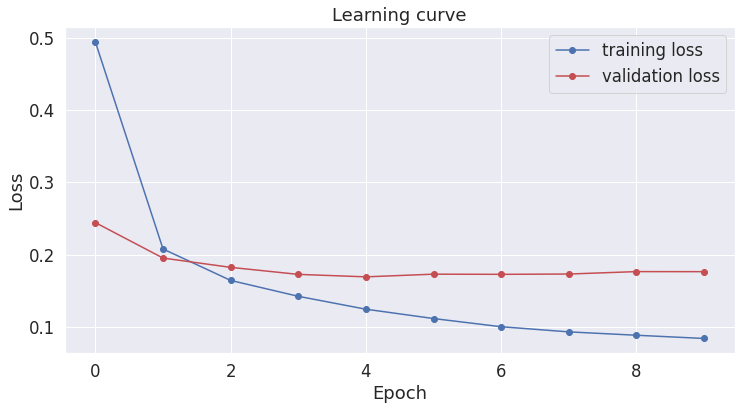

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [24]:
def predict_labels(test_data):
    sentences = get_sentences(test_data)

    predicted_labels = []

    for sentence in sentences:
        tokenized_sentence = tokenizer.encode(sentence)

        input_ids = torch.tensor([tokenized_sentence]).cuda()
        with torch.no_grad():
            output = model(input_ids)
        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)
        predicted_labels.extend(new_labels[1:-1])
    return predicted_labels

In [25]:
test_data1 = pd.read_csv("https://raw.githubusercontent.com/ffabi/szoweb/main/Test1NER.csv", encoding="latin1", sep=";").fillna(method="ffill")
test_data2 = pd.read_csv("https://raw.githubusercontent.com/ffabi/szoweb/main/Test2NER.csv", encoding="latin1", sep=";").fillna(method="ffill")


In [26]:
predicted_labels1 = predict_labels(test_data1)
out_test_data1 = pd.read_csv("https://raw.githubusercontent.com/ffabi/szoweb/main/Test1NER.csv", encoding="latin1", sep=";").fillna('')
out_test_data1 = out_test_data1.rename(columns={"Tag":"Predicted", "Sentence #":"Sentences"})
out_test_data1["Predicted"] = predicted_labels1


In [27]:
predicted_labels2 = predict_labels(test_data2)
out_test_data2 = pd.read_csv("https://raw.githubusercontent.com/ffabi/szoweb/main/Test2NER.csv", encoding="latin1", sep=";").fillna('')
out_test_data2 = out_test_data2.rename(columns={"Tag":"Predicted", "Sentence #":"Sentences"})
out_test_data2["Predicted"] = predicted_labels2
out_test_data2 = out_test_data2.drop(["POS"], axis=1)


In [28]:
out_test_data1.to_csv("Test1NER_Predicted.csv", index = False)
out_test_data2.to_csv("Test2NER_Predicted.csv", index = False)



In [29]:
# files.download('Test1NER_Predicted.csv')
# files.download('Test2NER_Predicted.csv')

In [30]:
print(sentences[0])
print(predicted_labels1[:len(sentences[0])])
print(len(predicted_labels1))
print(len(test_data1["Word"]))


['President', 'Karzai', 'thanked', 'his', 'allies', 'for', 'their', 'help', 'in', 'battling', 'terrorism', '.']
['O', 'B-time', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
19402
19402


In [32]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_true=valid_tags, y_pred=pred_tags, labels=keys, normalize="true")

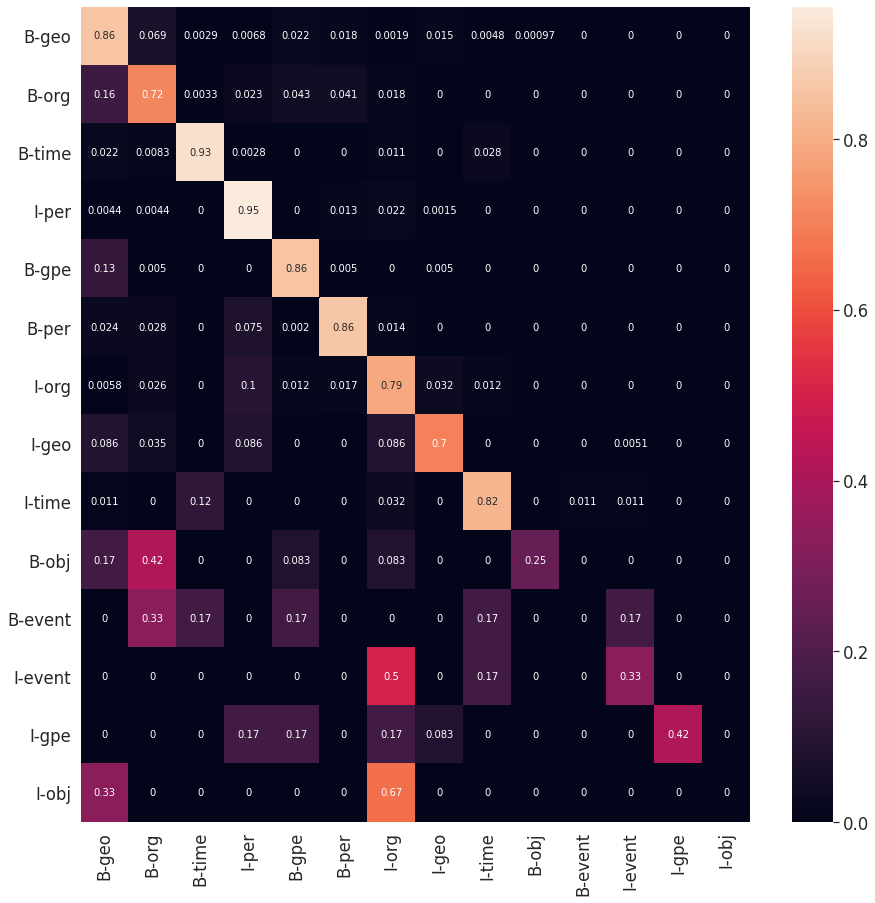

In [33]:
import seaborn as sn
df_cm = pd.DataFrame(array, index = keys, columns = keys)
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, xticklabels=True, yticklabels=True)